## ESTUDIO DE LOS FRACTALES: **El conjunto de Mandelbrot**
### Introducción: *¿Qué es un fractal?*

Los fractales son estructuras matemáticas que se repiten indefinidamente en diferentes escalas. Aunque el concepto puede sonar extraño o complejo, en realidad es un fenómeno muy comun en la naturaleza.

Por ejemplo, la forma de la hoja de un helecho se repite en cada una de sus hojas más pequeñas, y así indefinidamente

El término "fractal" fue acuñado por el matemático Benoît Mandelbrot, inventor del fractal que implementaremos en Python: **El conjunto de Mandelbrot**

### Condiciones iniciales: *¿Cómo generamos el conjunto de Mandelbrot?*

El conjunto de Mandelbrot contiene la serie de números complejos que van surgiendo al aplicar una y otra vez (**iterar**) la siguiente ecuación
$$
z_{n+1}=z_{n}^2 + c\;
$$
Para dibujar este fractal, se deben cumplir dos condiciones:
- $Z_0$ = 0
- El número complejo C, que da pie a la iteración no genere una serie de números cada vez mayores, cuyo límite tienda a infinito. Es decir, que C no haga no genere un número que diverga

En otras palabras, para determinar si un número complejo "C" pertenece al Conjunto de Mandelbrot debe verificar las condiciones anteriores. A partir de ese momento, C permanecerá constante al iterar la secuencia. Vemos un ejemplo práctico

### EJEMPLO 1: **Divergencia en el Conjunto de Mandelbrot**


In [ ]:
def z(n,c):
    if n == 0:
        return 0
    else:
        return z(n-1,c)**2 + c

for n in range(10):
    print(f"z({n}) = {z(n, c=1)}") #Llamamos a la función con un c = 1

Para c = 1, se puede observar la rápida tasa de crecimiento de los elementos. En menos de diez interacciones, nuestro número complejo se dispará hacia el infinito. Esto nos indica que c = 1 **no pertenece al conjunto de Mandelbrot**

### Representación **gráfica** del Conjunto de Mandelbrot
A continuación se muestra la implementación del fractal utilizando Python y una serie de librerías de utilidad paso a paso

### PASO 1: *librerías y condiciones iniciales*
```python
%matplotlib widget
import numpy as np
from numba import jit
```
**¿Cuál es la funcionalidad de [Numba](https://numba.readthedocs.io/en/stable/user/5minguide.html#what-is-object-mode)?**
- **Numba** es una librería utilizada para acelerar el código (sobre todo cuando tenememos largos bucles e iteraciones, como es el caso) a través de la compilación **just-in-time** (jit). 

- El compilador "jit" consigue que el código se lea directamente en **lenguaje máquina** consiguiendo que se ejecute más rápido, al no involucrar al intérprete de Python.
```python
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector

# Config. inicial:
RESOLUTION = 1000 
ITER_BASE = 80
VIEW_INITIAL = [-2.25, 0.75, -1.5, 1.5] 
INITIAL_WIDTH = VIEW_INITIAL[1] - VIEW_INITIAL[0]
```

### PASO 2: *Motor matemático*
El motor matemático será el algoritmo que nos genere el conjunto de Mandelbrot. Lo explicamos a continuación:
```python
@jit(nopython=True, fastmath=True)
def get_mandelbrot_data(bounds, max_iter, resolution):
    x_min, x_max, y_min, y_max = bounds
    
    # 1. Crear las rejillas
    real = np.linspace(x_min, x_max, resolution)
    imag = np.linspace(y_min, y_max, resolution)
    
    div_time = np.zeros((resolution, resolution), dtype=np.int32)
```
> La variable **div_time** será una matriz cuadrada con valores enteros de 32 bits (por ello, se añade al final de la definción de la variable "dtype=np.int32") que representan **la cantidad de iteraciones que han hecho falta hacer para que el Conjunto de Mandelbrot diverga**
```python
    rows, cols = div_time.shape
    
    for r in range(rows):
        cr = real[r]
        for c in range(cols):
            ci = imag[c]
            # Inicialización z0 = 0
            zr = 0.0 
            zi = 0.0 
            
            # Iteración z_new = z^2 + c -> fórmula del Conjunto de Mandelbrot
            for k in range(1, max_iter + 1):
                zr_sq = zr * zr
                zi_sq = zi * zi
```
> **FUNDAMENTO TEÓRICO:** Se dice que la sucesión $Z_n$ diverge cuando su módulo tiende a infinito. Sin embargo, en la práctica no podemos esperar a infinito, por lo que se demuestra que si el modulo de $Z_n$ > 2, entonces podemos asegurar que la serie de Mandelbrot diverge.

Las siguientes líneas de código muestran que...
- Si mi número diverge, es decir, es mayor que 2 (que es lo mismo que decir que su cuadrado es mayor que 4), entonces div_time será dicho valor "k" de la iteración (**recordamos que div_time era el nº en el cuál Mandelbrot divergía**).

- De no ser así, calculamos un nuevo **zr** y **zi**, cuyos valores hay que asignar a dos nuevas variables **zr_new** y **zi_new** (debido a la funcionalidad de Numba).

- En el caso de no encontrar un nº que cumpla los requisitos, asignará el valor "div_time" a la máxima iteración.
```python
                # Comprobación de divergencia (Magnitud^2 > 4)
                if zr_sq + zi_sq > 4.0:
                    div_time[c, r] = k
                    break
                    
                # Calcular la nueva z:
                zr_new = zr_sq - zi_sq + cr
                zi_new = 2.0 * zr * zi + ci
                
                zr = zr_new
                zi = zi_new
            else:
                div_time[c, r] = max_iter
    return div_time
```
### PASO 3: *Representación gráfica con [Matplotlib](https://matplotlib.org/stable/users/explain/quick_start.html)*
```python
fig, ax = plt.subplots(figsize=(8, 8))

# Ocultamos la interfaz estándar:
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

# Data inicial:
initial_data = get_mandelbrot_data(VIEW_INITIAL, ITER_BASE, RESOLUTION)

im = ax.imshow(
    initial_data, 
    cmap='magma', 
    origin='lower', 
    extent=VIEW_INITIAL, 
    interpolation='bilinear'
)
ax.set_aspect('equal')
ax.set_title(f"Zoom: 1.0x | Iter: {ITER_BASE}")
```
> Como vemos, la función principal es **ax.imshow**. Esta función se utiliza para mostrar imágenes o representar matrices en forma de mapa de colores (de manera que a cada valor/pixel le corresponde un color). Es decir, convierte una matriz de valores (en este caso, enteros) en una visualización **gráfica** donde los valores se traducen a colores. 

Dentro de esta función encontramos argumentos de interés como:

- **cmap** es un mapa de colores. Dicho sencillamente, aplica un gradiente de colores a los puntos.

- **origin** saca los ejes en el origen (0,0)

- **extent** define los limites de la ventana/box (izq, der, arriba, abajo). En este caso, "VIEW_INITIAL", los valores iniciales que definimos al principio

- **interpolation:** controla cómo imshow ajusta tu matriz a la resolución de la pantalla y cómo se ven los bordes y transiciones de color en la imagen.

### PASO 3: *Función de actualización*
La mejor forma de mostrar la magia de un fractal, ver como su estructura se define indefinidamente a diferentes escalas, es **programando un "zoom"**. Sin embargo, no realizamos un "zoom real", sino que **actualizamos y redibujamos la función** para unos nuevos límites que vendrán dados por el rectángulo que dibujemos en la imagen.

Es por ello por lo que se importa los **matplotlib.widgets** y, en concreto, el **Rectangle Selector**, que nos permite crear un selector de datos con forma rectangular.

Por tanto, para terminar de representar Mandelbrot, crearemos algunas funciones más: aquella que se encargue de actualizar la imagen; y las funciones que controlen al *Rectangle Selector*.
```python
# Función de actualización:

def update_plot(bounds, max_iter):
    # Nuevos datos
    new_data = get_mandelbrot_data(bounds, max_iter, RESOLUTION)
    
    im.set_data(new_data) # Cambiamos los pixeles
    im.set_extent(bounds) # Cambiamos las coordenadas de las esquinas
    im.set_clim(0, max_iter)
```
- En primer lugar, creamos los nuevos datos llamando a la función "get_mandelbrot_data", con unos bounds que vendrán dados por el Rectangle Selector

- La forma más óptima de actualizar la imagen es actualizando **SOLO** los datos. Para ello, utilizamos las funciones **im.set_data** y **im.set_extent** con una nueva data y unos nuevos límites (bounds), siendo "im" la función imagen que creamos unas líneas atrás.

- Por último, con **im.set_clim** ajustamos el rango de colores a las nuevas iteraciones, de forma que sigan generándose los colores adecuados.
```python
    
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])
    
    zoom_lvl = INITIAL_WIDTH / (bounds[1] - bounds[0])
    ax.set_title(f"Zoom: {zoom_lvl:.1f}x | Iter: {max_iter}")
    
    fig.canvas.draw_idle() #dibujar
```
**Por último, definimos el selector**. Este estará formado por 3 partes: *onselect* (función que almacenará unos datos cuando hacemos click **eclick** y cuando dejamos de hacer click **erelease**), *on_right_click* (función que permite volver atrás si hacemos click derecho) y *rect_Selector* (dibuja el selector).
```python
# Interacción:

def onselect(eclick, erelease):
    if eclick.xdata is None or erelease.xdata is None: return
    x0, x1 = sorted([eclick.xdata, erelease.xdata])
    y0, y1 = sorted([eclick.ydata, erelease.ydata])
    
    if abs(x1 - x0) < 1e-12: return # rectangulo tan pequeño que no se ejecuta
```
Uno de los problemas que encontramos al realizar este selector es que recortaba la ventana de la imagen en función del rectángulo que se dibujase, recortando la imagen cada vez más. Para solucionarlo, debemos **forzar a que la ventana sea cuadrada**

- Calculando el centro entre dos coordenadas (tanto de la x como de la y) y la distancia máxima del lado, si dividimos esta última cantidad entre dos obtendremos el **radio**. 

- Teniendo el centro y el radio, para forzar un cuadrado es tan simple como restar el radio de un lado, y sumárselo en el otro (y lo mismo para el eje y)
```python
    # Forzar ventana cuadrada
    center_x = (x0 + x1) / 2.0
    center_y = (y0 + y1) / 2.0
    max_side = max(x1 - x0, y1 - y0)
    radius = max_side / 2.0
    
    new_bounds = [
        center_x - radius, center_x + radius,
        center_y - radius, center_y + radius
    ]
    
    # Calcular iteraciones
    zoom_factor = INITIAL_WIDTH / max_side
    new_iter = int(ITER_BASE + 40 * np.log2(zoom_factor))
    new_iter = min(new_iter, 3000)

    update_plot(new_bounds, new_iter)
```
**Calculamos el zoom y el nuevo número de iteraciones con las siguientes fórmulas**, las cuales se sacan de la teoría y de la [guía](https://matplotlib.org/stable/users/explain/quick_start.html) de la librería
$$
\text{zoom\_factor} = \frac{\text{INITIAL\_WIDTH}}{\text{max\_side}}
$$

$$
\text{new\_iter} = \text{ITER\_BASE} + 40 \cdot \log_2(\text{zoom\_factor})
$$
```python
    # Limpiar el rectángulo del selector después de actualizar
    # Esto borra el rastro visual del rectángulo de selección.
    rect_selector.clear()


def on_right_click(event):
    if event.button == 3: # el botón der. para 'event' == 3
        update_plot(VIEW_INITIAL, ITER_BASE)
        rect_selector.clear()
```
**Función on_right_click:**
- Dentro de esta función, comprobamos si "event.button == 3", lo cual corresponde a haber pulsado el botón derecho del ratón.

- Si se cumple dicha condición, se llama a la función **update_plot** con los valores iniciales **VIEW_INITIAL** e **ITER_BASE** lo que hará que, lógicamente, se genere la primera imagen del Conjunto de Mandelbrot, la inicial.

- Por último, con **rect_selector.clear()** limpiamos las selecciones previas y no se acumulen en la imagen.
```python
# Selector
rect_selector = RectangleSelector(
    ax, onselect,
    useblit=True, # Importante dejar esto en True para fluidez
    button=[1], 
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True,
    props=dict(facecolor='white', edgecolor='cyan', alpha=0.2, fill=True)
)
```
**El Selector:** dentro del selector nos encontramos con algunos argumentos nuevos como:
- **useblit=True** mejora la fluidez de la selección, haciendo que el rectángulo se dibuje de forma más rápida sin redibujar toda la figura.

- **button=[1]** indica que el selector solo responde al clic izquierdo del ratón

- **minspanx y minspany** establecen el tamaño mínimo de la selección en píxeles para evitar selecciones accidentales demasiado pequeñas. 

- **spancoords='pixels'** asegura que las medidas mínimas se interpreten en píxeles en lugar de unidades de datos.
```python
fig.canvas.mpl_connect('button_press_event', on_right_click)

plt.show()
```
### PASO 4: *Juntar todas las partes, (cruzar los dedos), y observar la magia del Conjunto de Mandelbrot*
**Código completo**

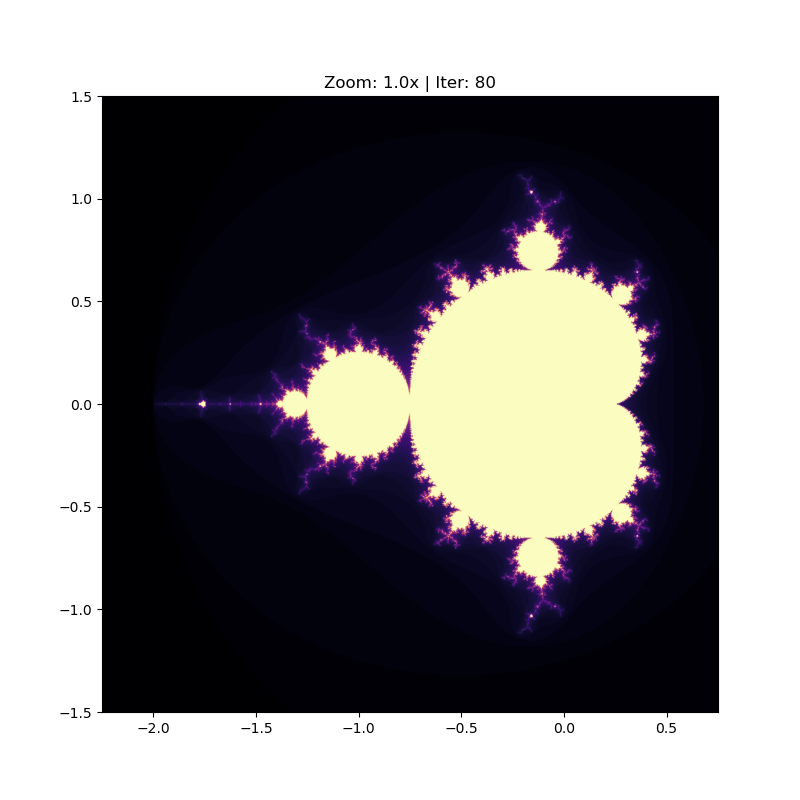

In [1]:
%matplotlib widget
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector

# Config. inicial:
RESOLUTION = 1000 
ITER_BASE = 80
VIEW_INITIAL = [-2.25, 0.75, -1.5, 1.5] 
INITIAL_WIDTH = VIEW_INITIAL[1] - VIEW_INITIAL[0]

@jit(nopython=True, fastmath=True)
def get_mandelbrot_data(bounds, max_iter, resolution):
    x_min, x_max, y_min, y_max = bounds
    
    # 1. Crear las rejillas
    real = np.linspace(x_min, x_max, resolution)
    imag = np.linspace(y_min, y_max, resolution)
    
    div_time = np.zeros((resolution, resolution), dtype=np.int32)
    
    rows, cols = div_time.shape
    
    for r in range(rows):
        cr = real[r]
        for c in range(cols):
            ci = imag[c]
            # Inicialización z0 = 0
            zr = 0.0 
            zi = 0.0 
            
            # Iteración z_new = z^2 + c -> fórmula del Conjunto de Mandelbrot
            for k in range(1, max_iter + 1):
                zr_sq = zr * zr
                zi_sq = zi * zi
                # Comprobación de divergencia (Magnitud^2 > 4)
                if zr_sq + zi_sq > 4.0:
                    div_time[c, r] = k
                    break
                    
                # Calcular la nueva z:
                zr_new = zr_sq - zi_sq + cr
                zi_new = 2.0 * zr * zi + ci
                
                zr = zr_new
                zi = zi_new
            else:
                div_time[c, r] = max_iter
    return div_time

fig, ax = plt.subplots(figsize=(8, 8))

# Ocultamos la interfaz estándar:
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

# Data inicial:
initial_data = get_mandelbrot_data(VIEW_INITIAL, ITER_BASE, RESOLUTION)

im = ax.imshow(
    initial_data, 
    cmap='magma', 
    origin='lower', 
    extent=VIEW_INITIAL, 
    interpolation='bilinear'
)
ax.set_aspect('equal')
ax.set_title(f"Zoom: 1.0x | Iter: {ITER_BASE}")

# Función de actualización:

def update_plot(bounds, max_iter):
    # Nuevos datos
    new_data = get_mandelbrot_data(bounds, max_iter, RESOLUTION)
    
    im.set_data(new_data) # Cambiamos los pixeles
    im.set_extent(bounds) # Cambiamos las coordenadas de las esquinas
    im.set_clim(0, max_iter)
    
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])
    
    zoom_lvl = INITIAL_WIDTH / (bounds[1] - bounds[0])
    ax.set_title(f"Zoom: {zoom_lvl:.1f}x | Iter: {max_iter}")
    
    fig.canvas.draw_idle() #dibujar

# Interacción:

def onselect(eclick, erelease):
    if eclick.xdata is None or erelease.xdata is None: return
    x0, x1 = sorted([eclick.xdata, erelease.xdata])
    y0, y1 = sorted([eclick.ydata, erelease.ydata])
    
    if abs(x1 - x0) < 1e-12: return # rectangulo tan pequeño que no se ejecuta

    # Forzar ventana cuadrada
    center_x = (x0 + x1) / 2.0
    center_y = (y0 + y1) / 2.0
    max_side = max(x1 - x0, y1 - y0)
    radius = max_side / 2.0
    
    new_bounds = [
        center_x - radius, center_x + radius,
        center_y - radius, center_y + radius
    ]
    
    # Calcular iteraciones (esto es una formula que es así, se saca de la guía)
    zoom_factor = INITIAL_WIDTH / max_side
    new_iter = int(ITER_BASE + 40 * np.log2(zoom_factor))
    new_iter = min(new_iter, 3000)

    update_plot(new_bounds, new_iter)
    
    # Limpiar el rectángulo del selector después de actualizar
    # Esto borra el rastro visual del rectángulo de selección.
    rect_selector.clear()


def on_right_click(event):
    if event.button == 3: # el botón der. para 'event' == 3
        update_plot(VIEW_INITIAL, ITER_BASE)
        rect_selector.clear()


# Selector
rect_selector = RectangleSelector(
    ax, onselect,
    useblit=True, # Importante dejar esto en True para fluidez
    button=[1], 
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True,
    props=dict(facecolor='white', edgecolor='cyan', alpha=0.2, fill=True)
)

fig.canvas.mpl_connect('button_press_event', on_right_click)

plt.show()